<a href="https://colab.research.google.com/github/Narusi/My-Projects/blob/master/RevolutPortfolioNewAssets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Necessary libraries

In [1]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=d14aa53354be44612d1ad2224e0e700daf81968fb1274a1c8a6fc95d19d2cfe4
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [2]:
from google.colab import drive

import pandas as pd
import numpy as np
import itertools
from scipy.stats import pearsonr, spearmanr

import requests
from bs4 import BeautifulSoup

import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=3)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Simple Momentum

In [0]:
def momentumBuy(close, asset='Asset', step=50, rper=1, output='current', chart=False, printOut=False):
    shortBuy = close > close.rolling(step).mean()
    mediumBuy = close > close.rolling(step * 2).mean()
    longBuy = close > close.rolling(step * 4).mean()

    medMBuy = close.rolling(step).mean() > close.rolling(step * 2).mean()
    longMBuy = close.rolling(step).mean() > close.rolling(step * 4).mean()

    veryLongBuy = close.rolling(step * 2).mean() > close.rolling(200).mean()

    buySignals = pd.DataFrame(index=close.index)

    buySignals['BuySS'] = shortBuy
    buySignals['BuySM'] = mediumBuy
    buySignals['BuySL'] = longBuy
    buySignals['BuyMM'] = medMBuy
    buySignals['BuyML'] = longMBuy
    buySignals['BuyLL'] = veryLongBuy

    ts = pd.DataFrame({asset:close.div(close.iloc[0]),
                    'Returns':np.log(close/close.shift(rper)).shift(rper),
                    'BuySignal':buySignals.sum(axis=1)},
                    index=close.index)

    momSum = ts.groupby('BuySignal')['Returns'].sum()
    momMed = ts.groupby('BuySignal')['Returns'].median()
    buySigns = []
    holdSignal = []
    sellSign = []
    losingSignals = momSum[momSum <= 0.0].index

    for bl in range(len(momSum.index)-1,0,-1):        
        if np.logical_and(momSum[bl] > 0.0, bl > max(losingSignals)):
            buySigns.append(bl)
        elif momSum[bl] > 0.0:
            holdSignal.append(bl)
        elif momMed[bl] <= 0.0:
            sellSign.append(bl)

    ts['Signal'] = ''
    ts.loc[ts[ts['BuySignal'] == 0].index, 'Signal'] = 'SELL'
    
    if len(buySigns) > 1:
        for buy in buySigns:
            ts.loc[ts[ts['BuySignal'] == buy].index, 'Signal'] = 'BUY'
    elif len(buySigns) == 1:
        ts.loc[ts[ts['BuySignal'] == buySigns[0]].index, 'Signal'] = 'BUY'
        
    if len(holdSignal) > 1:
        for hold in holdSignal:
            ts.loc[ts[ts['BuySignal'] == hold].index, 'Signal'] = 'HOLD'
    elif len(holdSignal) == 1:
        ts.loc[ts[ts['BuySignal'] == holdSignal[0]].index, 'Signal'] = 'HOLD'

    if len(sellSign) > 1:
        for sell in sellSign:
            ts.loc[ts[ts['BuySignal'] == sell].index, 'Signal'] = 'SELL'
    elif len(sellSign) == 1:
        ts.loc[ts[ts['BuySignal'] == sellSign[0]].index, 'Signal'] = 'SELL'

    for b in buySignals.columns:    
        rets = ts['Returns'][buySignals[b]]
        prob = rets[rets > 0.0].count()/rets.count()    
        if printOut: print(b, prob, rets.mean());

        ts[b] = 0
        ts.loc[buySignals[buySignals[b]].index, b] = 1

    if chart:
        ts['2018':][[asset,'BuySignal']].plot(figsize=(16,8))
        plt.show();

    if printOut: print(ts.groupby('BuySignal')['Returns'].mean());
    
    for i in range(min(6, len(momSum.index)-1)):
        minpick = ts.loc[ts[ts['BuySignal'] >= i].index]
        probs = minpick.groupby('BuySignal')['Returns'].count()/minpick['Returns'].count()    
        rets = minpick.groupby('BuySignal')['Returns'].mean()
        std = minpick.groupby('BuySignal')['Returns'].std()

        dprobs = minpick[minpick['Returns'] < 0.0].groupby('BuySignal')['Returns'].count()/minpick.groupby('BuySignal')['Returns'].count()
        #print((probs * rets).sum())
        #print(dprobs)
    
    ts['14.DAYS'] = ts['Returns'].rolling(14).sum().shift(14)
    ts['28.DAYS'] = ts['Returns'].rolling(28).sum().shift(28)
    ts['60.DAYS'] = ts['Returns'].rolling(60).sum().shift(60)
    ts['90.DAYS'] = ts['Returns'].rolling(90).sum().shift(90)
    lags = ['14.DAYS','28.DAYS','60.DAYS','90.DAYS']
    
    signalProbs = pd.DataFrame(index=list(range(len(list(itertools.product([1, 0], repeat = len(buySignals.columns)))))),
                               columns=list(buySignals.columns) + lags)
    signalProbs[buySignals.columns] = 0
    signalProbs[lags] = 0.0

    signalReturns = pd.DataFrame(index=list(range(len(list(itertools.product([1, 0], repeat = len(buySignals.columns)))))), 
                                 columns=list(buySignals.columns) + lags)
    signalReturns[buySignals.columns] = 0
    signalReturns[lags] = 0.0

    i = 0
    for comb in itertools.product([1, 0], repeat = len(buySignals.columns)):
        comb = list(comb)
        signalProbs.loc[i, buySignals.columns] = comb

        signInd = buySignals[buySignals == comb].dropna().index
        signRets = ts[lags].reindex(signInd)
        theProbs = signRets[signRets >= 0.05/step].count()/signRets.count()
        
        signalProbs.loc[i, lags] = theProbs
        signalReturns.loc[i, lags] = signRets.mean()
        i += 1
    
    for ss in buySignals.columns:
        rets = ts[ts[ss] == 1][lags].dropna()
        prob = rets[rets > 0.01].count()/rets.count()
        hrets = rets[rets > 0.01].mean()

        if printOut:
            print('\n',ss)
            print(rets.mean(), '\n',rets.median())
            print('\nProbabilities:')
            print(prob.mean())
            print((prob * hrets).mean())
    
    if printOut: print(ts.groupby('Signal')['Returns'].mean());
    
    if output == 'current' or output == 'single':
        currentState = (np.array(signalProbs[buySignals.columns].values) == np.array(ts[buySignals.columns].iloc[-1].values)).sum(axis=1) == len(buySignals.columns)
        lagOutput = []
        for lagProb in lags:
            action = ''
            if signalProbs[currentState][lagProb].values[0] > 0.75: action = 'BUY'
            elif signalProbs[currentState][lagProb].values[0] > 0.50: action = 'HOLD'
            elif signalProbs[currentState][lagProb].values[0] <= 0.50: action = 'SELL'

            lagOutput.append([lagProb, action, 
                            signalProbs[currentState][lagProb].values[0], 
                            signalReturns[currentState][lagProb].values[0]])

            if printOut:
                print(lagProb, action, 
                    round(100*signalProbs[currentState][lagProb].values[0],1),
                    round(100*signalReturns[currentState][lagProb].values[0],3))                
        
        if output == 'single':
            ttemp = pd.DataFrame(lagOutput)        
            return ttemp.loc[ttemp[2].idxmin(), 1]
        else:
            return lagOutput

    elif output == 'ts':
        return ts

In [0]:
def simpleMomentum(close, step=50, per=22, output='double', verbose=False):
    #Standard Momentum signals:
    shortBuy = close > close.rolling(step).mean()
    mediumBuy = close > close.rolling(step * 2).mean()
    longBuy = close > close.rolling(step * 4).mean()
    medMBuy = close.rolling(step).mean() > close.rolling(step * 2).mean()
    longMBuy = close.rolling(step).mean() > close.rolling(step * 4).mean()
    veryLongBuy = close.rolling(step * 2).mean() > close.rolling(200).mean()
    signal = ''

    buySignals = pd.DataFrame(index=close.index)
    buySignals['BuySS'] = shortBuy
    buySignals['BuySM'] = mediumBuy
    buySignals['BuySL'] = longBuy
    buySignals['BuyMM'] = medMBuy
    buySignals['BuyML'] = longMBuy
    buySignals['BuyLL'] = veryLongBuy
    buySignals['FRET'] = close.shift(-per)/close - 1

    current = buySignals.iloc[-1]
    hret = buySignals
    momSignals = ['BuySS','BuySM','BuySL','BuyMM','BuyML','BuyLL']
    strongBuy = pd.DataFrame()
    
    if hret.groupby(momSignals)['FRET'].min().max() > 0.0:
        hr = hret.groupby(momSignals)['FRET'].min()
        strongBuy = hr[hr>0.0]

    for s in momSignals:
        hret = buySignals[buySignals[s]==current[s]]
    
    if len(strongBuy.index) > 0:
        for i in strongBuy.index:
            if current[momSignals].to_list() == list(i): signal = 'STRONG BUY'
        

    profProb = hret['FRET'][hret['FRET'] > 0.01].count()/hret['FRET'].count()    
    avgRet = hret['FRET'].mean()

    if signal != 'STRONG BUY':
        if profProb/(1.-profProb) > 3. and avgRet > 0.0:
            signal = 'STRONG BUY'
        elif profProb/(1.-profProb) >= 2. and avgRet > 0.0:
            signal = 'BUY'
        elif profProb/(1.-profProb) <= 1.:
            signal = 'SELL'
        else:
            signal = 'HOLD'

    if output == 'single':
        return signal
    elif output == 'double':
        return signal, avgRet
    elif output == 'triple':
        return signal, avgRet, profProb
    elif output == 'current':
        return signal, profProb, lossProb, current    
    elif output == 'hret':
        return hret


In [5]:
a = 'HMY'
pps = yf.download(a)['Adj Close']

timeSeries = momentumBuy(pps, asset=a, rper=22, output='ts')
print(a, ' current state {}\n\n'.format(timeSeries['BuySignal'].iloc[-1]), 
      timeSeries.groupby(['Signal','BuySignal'])['Returns'].mean())
print(timeSeries.index[-1], '\n')

momentumBuy(pps, asset=a, rper=22, output='single'), simpleMomentum(pps, per=22, output='single')

[*********************100%***********************]  1 of 1 completed
HMY  current state 4

 Signal  BuySignal
BUY     3            0.015550
        4            0.018773
        5            0.047471
        6            0.107452
SELL    0           -0.091595
        1           -0.052632
        2           -0.000805
Name: Returns, dtype: float64
2020-05-15 00:00:00 



('SELL', 'SELL')

# Machine Learning section

In [0]:
def featurize(x, per=22, tRet='auto', verbose=False):
    import numpy as np
    import pandas as pd
    from scipy.stats import pearsonr, spearmanr
    
    """
    x -        Pandas series with prices of an assset
    per -      Investment period
    tRet -     Target return. [tuple, 'auto', float]
               If tuple both targets are expected -> (lower, upper)
               If "Auto" then arithmetic mean return will be used for upper and lower bound. 
               Otherwise a float.
    """
    if tRet == 'auto':
        ret = np.log(x/x.shift(per)).fillna(0.0)
        lRet = -ret.mean()
        uRet = ret.mean()
    elif type(tRet) == float:
        lRet = -tRet
        uRet = tRet        
    elif type(tRet) == tuple:
        lRet, uRet = tRet
    
    ubnd = x * (1 + uRet)
    lbnd = x * (1 + lRet)
    
    y = np.zeros(shape=(len(x),1))
    y[x >= ubnd.shift(-per)] = 1
    y[x <= lbnd.shift(-per)] = -1
    
    if verbose:
        for i in range(-1,2,1):
            print(i, len(y[y==i])/len(y))
    
    X = pd.DataFrame(index=x.index)
    X['P'] = x
    if per >= 5:
        X['P'+str(int(per/2))] = np.log(x/x.shift(int(per/2)))
    X['P'+str(per)] = np.log(x/x.shift(per)).fillna(0.0)
    X['P'+str(2*per)] = np.log(x/x.shift(2*per)).fillna(0.0)
    
    X['P50'] = x.pct_change(50).fillna(0.0)
    X['P100'] = x.pct_change(100).fillna(0.0)
    X['P200'] = x.pct_change(200).fillna(0.0)

    X['50'] = x.rolling(50).mean()
    X['100'] = x.rolling(100).mean()
    X['200'] = x.rolling(200).mean()
    
    X['P/50'] = x/X['50']
    X['P/100'] = x/X['100']
    X['P/200'] = x/X['200']
    X['50/100'] = X['50']/X['100']
    X['100/200'] = X['100']/X['200']
    X['50/200'] = X['50']/X['200']
    
    X['Pc'] = 0
    X['P/50c'] = 0
    X['P/100c'] = 0
    X['P/200c'] = 0
    X['50/100c'] = 0
    X['100/200c'] = 0
    X['50/200c'] = 0

    X['Ps'] = 0
    X['P/50s'] = 0
    X['P/100s'] = 0
    X['P/200s'] = 0
    X['50/100s'] = 0
    X['50/200s'] = 0
    X['100/200s'] = 0
    
    #X['Ps']
    for i in X.index:
        for c in ['P/50','P/100','P/200','50/100','100/200','50/200']:
            if X.loc[i, c] > 1.0:
                if X.shift(1).loc[i, c+'c'] > 0:
                    X.loc[i, c+'c'] = X.shift(1).loc[i, c+'c'] + 1
                else:
                    X.loc[i, c+'c'] = 1
    
    for c in ['P/50c','P/100c','P/200c','50/100c','100/200c','50/200c']:
        X[c][np.logical_and(X[c]>0,X[c]<=5)] = 1
        X[c][np.logical_and(X[c]>5,X[c]<=10)] = 2
        X[c][np.logical_and(X[c]>10,X[c]<=20)] = 3
        X[c][np.logical_and(X[c]>20,X[c]<=50)] = 4
        X[c][X[c]>50] = 0

        cc = str(c)[:-1]
        s = cc+'s'
        
        long = X[np.logical_and(X[cc]>=1., X[cc].shift(1)<1.)].index
        if len(long)>0: X.loc[long, s] = 1;
        short = X[np.logical_and(X[cc]<=1., X[cc].shift(1)>1.)].index
        if len(short) > 0: X.loc[short, s] = -1;
    
    #X = X[['P'+str(per),'P/50','P/100','P/200','50/100','100/200','50/200',
    #       'P/50c','P/100c','P/200c','50/100c','100/200c','50/200c']]
    X = X.fillna(0.0)

#    for c in X.columns:
#        xc = (X[c]-X[c].mean())/X[c].std()
#        pears = pearsonr(xc.values, y[:,0])
#        spear = spearmanr(xc.values, y[:,0])
#        if pears[1] < spear[1]:
            #print(c,'Pearson',pears)
#            if pears[0] < 0.099: 
#                if verbose:print('Droping ',c);
                #X = X.drop(c,axis=1)
#        else:
            #print(c,spear)
#            if spear[0] < 0.1: 
#                if verbose: print('Droping ',c);
                #X = X.drop(c,axis=1)
    return X, y.ravel()


In [7]:
def momentum(prices, per=22, output='return/risk'):
    X,y = featurize(prices,per=per)
    X['ret'] = prices.shift(-per)/prices - 1

    cols = []
    for c in X.columns:
        if str(c)[-1] == 'c' or str(c)[-1] == 's': cols.append(c);
    
    mu = X.groupby(cols)['ret'].median()
    sigma = X.groupby(cols)['ret'].std()
    curr = tuple(X.iloc[-1][cols])

    if output == 'return/risk':
        return mu[curr], sigma[curr]
    elif output == 'return':
        return mu[curr]
    elif output == 'risk':
        return sigma[curr]
    elif output == 'return table':
        return mu
    elif output == 'risk rable':
        return sigma

momentum(yf.download('NVDA')['Adj Close'], output='return')

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to b

-0.023766188740029892

In [0]:
def svmMom(X, y, per=22,opt=False,backTest=False,showRet=False):
    from sklearn.svm import SVC
    import numpy as np
    import pandas as pd
    
    clf = SVC(gamma='auto')
    X = (X - X.mean())/X.std()
    if backTest:           
        clf.fit(X.iloc[:-per], y[:-per])        
        return clf
    else:
        clf.fit(X.iloc[:-252], y[:-252])
        predScore = clf.score(X.iloc[-252:-per],y[-252:-per])

        clf.fit(X.iloc[:-per],y[:-per])
        pred = int(clf.predict(X.iloc[-1:])[0])
        
        return pred, predScore

def rfcMom(X,y, per=22,opt=False,backTest=False,showRet=False):
    from sklearn.ensemble import RandomForestClassifier
    import numpy as np
    import pandas as pd
    
    if opt:
        max_n = np.shape(X)[1] * 2
        k = 1
        maxScore = 0.0
        ret = X.iloc[-252:-per, 1]
        X = (X - X.mean())/X.std()
        
        for i in range(1, max_n):
            clf = RandomForestClassifier(n_estimators=k*25)
            clf.fit(X.iloc[:-252],y[:-252])

            pred = clf.predict(X.iloc[-252:-per])        
            profit = np.mean(np.multiply(pred[pred==1], ret[pred==1]))
            profit -= np.mean(np.multiply(pred[pred==-1], ret[pred==-1]))
            #print('Profit: ', profit)
            if  profit > maxScore:
                maxScore = profit
                k = i
    else:
        k=2
    
    clf = RandomForestClassifier(n_estimators=k*50)
    clf.fit(X.iloc[:-per],y[:-per])
    if backTest:
        return clf
    else:
        clf.fit(X.iloc[:-252], y[:-252])
        predScore = clf.score(X.iloc[-252:-per],y[-252:-per])

        clf.fit(X.iloc[:-per],y[:-per])
        pred = int(clf.predict(X.iloc[-1:])[0])
        
        if showRet:
            return pred, predScore, maxScore
        else:
            return pred, predScore

def kncMom(X,y,per=22,opt=False,backTest=False,showRet=False):
    from sklearn.neighbors import KNeighborsClassifier
    import numpy as np
    import pandas as pd
    
    if opt:
        max_n = np.shape(X)[1]
        k = 1
        maxScore = 0.0
        ret = X.iloc[-252:-per, 1]
        X = (X - X.mean())/X.std()
        for i in range(1, max_n-1):
            clf = KNeighborsClassifier(n_neighbors=i)
            clf.fit(X.iloc[:-252],y[:-252])

            pred = clf.predict(X.iloc[-252:-per])        
            profit = np.mean(np.multiply(pred[pred==1], ret[pred==1]))
            profit -= np.mean(np.multiply(pred[pred==-1], ret[pred==-1]))
            #print('Profit: ', profit)
            if  profit > maxScore:
                maxScore = profit
                k = i
    else:
        k = 6

    clf = KNeighborsClassifier(n_neighbors=k)
    if backTest:         
        clf.fit(X.iloc[:-per],y[:-per])
        return clf
    else:
        clf.fit(X.iloc[:-252], y[:-252])
        predScore = clf.score(X.iloc[-252:-per],y[-252:-per])

        clf.fit(X.iloc[:-per],y[:-per])
        pred = int(clf.predict(X.iloc[-1:])[0])
        
        if showRet:
            return pred, predScore, maxScore
        else:
            return pred, predScore

def gbcMom(X,y,per=22,opt=False,backTest=False,showRet=False):
    from sklearn.ensemble import GradientBoostingClassifier
    import numpy as np
    import pandas as pd
    
    ret = X.iloc[-252:-per, 1]
    if opt:
        max_n = np.shape(X)[1] * 2
        k = 1
        maxScore = 0.0

        for i in range(1, max_n):
            clf = GradientBoostingClassifier(n_estimators = k * 25)
            clf.fit(X.iloc[:-252],y[:-252])
            pred = clf.predict(X.iloc[-252:-per])
            
            profit = np.mean(np.multiply(pred[pred==1], ret[pred==1]))
            profit -= np.mean(np.multiply(pred[pred==-1], ret[pred==-1]))
            #print('Profit: ', profit)
            if  profit > maxScore:
                maxScore = profit
                k = i
    else:
        k = 4

    clf = GradientBoostingClassifier(n_estimators = k * 25)
    clf.fit(X.iloc[:-per],y[:-per])
    
    if backTest:
        return clf
    else:        
        pred = int(clf.predict(X.iloc[-1:])[0])
        clf.fit(X.iloc[:-252], y[:-252])
        predScore = clf.score(X.iloc[-252:-per],y[-252:-per])
        
        if showRet:
            pred = clf.predict(X.loc[ret.index])
            stratRet = np.mean(np.multiply(pred[pred==1], ret[pred==1]))
            stratRet -= np.mean(np.multiply(pred[pred==-1], ret[pred==-1]))
            return pred, predScore, stratRet
        else:
            return pred, predScore

a = 'SWED-A.ST'
p = 22
#pr = yf.download(a, period='10y')['Adj Close']
#r = (pr.shift(p)/pr - 1).fillna(0.0)

#X,y = featurize(apr, per=p)
#print('Obtained X and y for {}\n'.format(a))

#print('SVM', svmMom(X,y,per=p,showRet=True))
#print('RFC', rfcMom(X,y,per=p,showRet=True,opt=True))
#print('RFC', rfcMom(X,y,per=p,showRet=True))
#print('GBC', gbcMom(X,y,per=p,showRet=True,opt=True))
#print('GBC', gbcMom(X,y,per=p,showRet=True))
#print('KNN', kncMom(X,y,per=p,showRet=True))

# Backtesting

In [0]:
def backtestMLmomentum(bt, tPeriod=252, hPeriod=30, 
                       verbose=False, useAccuracy=False, 
                       getPrediction=False, opt=False):
    testPeriod = tPeriod # Testing period in days
    h = hPeriod #Investment horizon in days
    models = ['SVM','GBC','RFC','KNN']
    
    if bt.count().min() <= 2*tPeriod + 201:        
        print('Backtesting requires at least {} records of prices.'.format(2*tPeriod + 201))
        print(bt.count().min(), ' records passed.')
        return 0

    results = pd.DataFrame(index=bt.columns)
    if useAccuracy: accuracy = pd.DataFrame(index=bt.columns)
    for m in models:
        results[m+' Long Ret'] = .0
        results[m+' Max Loss'] = .0
        results[m+' AVG LR'] = .0
        
        if useAccuracy:
            accuracy[m+' Hit Rate'] = .0
            accuracy[m+' Miss Rate'] = .0
            accuracy[m+' Score'] = .0

    if getPrediction: preDF = pd.Series(index=bt.columns);
    for a in bt.columns:
        if verbose: print(a);

        #Define past day and future investment forizon returns
        pp = bt[a][-testPeriod:]
        ret = np.log(pp/pp.shift(1))
        fret = np.log(pp.shift(-h)/pp).fillna(0.0)

        #Creating training and testing datasets
        low = -(0.01/22)*h
        high = (0.03/22)*h
        X, y = featurize(bt[a].dropna(), per=h, tRet=(low,high))
        X_train, y_train = X[:-testPeriod], y[:-testPeriod]
        X_test, y_test = X[-testPeriod:], y[-testPeriod:]

        #Training the trading models
        if opt:
            svm = svmMom(X_train, y_train, per=h, backTest=True)
            rfc = rfcMom(X_train, y_train, per=h, opt=True, backTest=True)
            knc = kncMom(X_train, y_train, per=h, opt=True, backTest=True)
            gbc = gbcMom(X_train, y_train, per=h, opt=True, backTest=True)
        else:
            svm = svmMom(X_train, y_train, per=h, backTest=True)
            rfc = rfcMom(X_train, y_train, per=h, backTest=True)
            knc = kncMom(X_train, y_train, per=h, backTest=True)
            gbc = gbcMom(X_train, y_train, per=h, backTest=True)

        #Calculating model scores
        scores = [
            round(svm.score(X_test, y_test),4),
            round(gbc.score(X_test, y_test),4),
            round(rfc.score(X_test, y_test),4),
            round(knc.score(X_test, y_test),4)
        ]

        #Storing model predictions for test set
        predictions = [
            np.array(svm.predict(X_test)),
            np.array(gbc.predict(X_test)),
            np.array(rfc.predict(X_test)),
            np.array(knc.predict(X_test))
        ]

        #Savign he results in dataframe and printing out few key points
        if verbose: print('Historical profitability:');
        if getPrediction:
            modelTable = pd.DataFrame(index=models, columns=list(['RET','HIT','HITL',
                                                                  'MISS','SC','WINR',
                                                                  'COUNT','AVGR','AVGL']),
                                      dtype=float)
            
        for m in range(len(models)):
            hit = ret[np.logical_and(predictions[m] == 1, fret > high)].count()
            miss = ret[np.logical_and(predictions[m] == 1, fret < low)].count()
            predicted = len(predictions[m][predictions[m] == 1])
            predicLoss = ret[np.logical_and(predictions[m] == -1, fret < low)].count()
            actual = len(predictions[m][fret > .03])
            
            results.loc[a, models[m]+' Long Ret'] = round(ret.shift(-1)[predictions[m] == 1].sum(),4)
            results.loc[a, models[m]+' Max Loss'] = round(fret[predictions[m] == 1].min(),4)
            results.loc[a, models[m]+' AVG LR'] = round(fret[predictions[m] == 1].mean(),4)
            
            if getPrediction:
                modelTable.loc[models[m],'RET'] = results.loc[a, models[m]+' Long Ret']/predicted
                modelTable.loc[models[m],'HIT'] = hit
                modelTable.loc[models[m],'HITL'] = predicLoss/len(predictions[m][predictions[m] == -1])
                modelTable.loc[models[m],'MISS'] = miss
                modelTable.loc[models[m],'SC'] = scores[m]
                modelTable.loc[models[m],'WINR'] = np.dot(predictions[m], fret)
                modelTable.loc[models[m],'COUNT'] = predicted
                modelTable.loc[models[m],'AVGR'] = round(fret[predictions[m] == 1].mean(),4)
                modelTable.loc[models[m],'AVGL'] = round(fret[predictions[m] == -1].mean(),4)
        if verbose: print(a,'\n', modelTable);

        if getPrediction:
            #modelTable['RATE'] = ((modelTable-modelTable.min())/(modelTable.max()-modelTable.min())).sum(axis=1)
            #modelTable['RATE'] = modelTable['RATE']*(1+modelTable['AVGR'])**h
            model = modelTable['WINR'].idxmax()

            if model == 'SVM':
                preDF[a] = svmMom(X,y)[0]
            elif model == 'RFC':
                preDF[a] = rfcMom(X,y)[0]
            elif model == 'GBC':
                preDF[a] = gbcMom(X,y)[0]
            elif model == 'KNN':
                preDF[a] = kncMom(X,y)[0]

            if useAccuracy:
                accuracy.loc[a, models[m]+' Hit Rate'] = hit/actual
                accuracy.loc[a, models[m]+' Miss Rate'] = miss/predicted
                accuracy.loc[a, models[m]+' Score'] = scores[m]
            
            if verbose:
                if predicted == 0:
                    print(models[m], '({}/{})'.format(predicted,actual))
                else:
                    print(models[m], '({}/{})'.format(predicted,actual),'\n',
                          'Hit Rate:    ',accuracy.loc[a, models[m]+' Hit Rate'],'\n',
                          'Miss Rate:   ',accuracy.loc[a, models[m]+' Miss Rate'],'\n',
                          'Max. loss:  ',fret[predictions[m] == 1].min(),'\n',
                          'Mean profit: ',fret[predictions[m] == 1].mean())
        if verbose: print('=====================================\n');
        
    if useAccuracy:
        return results, accuracy
    elif getPrediction:
        return preDF
    else:        
        return results

#backtestMLmomentum(yf.download(['TSLA','AAPL'])['Adj Close'], 
#                   tPeriod=252, hPeriod=22, getPrediction=True)

In [0]:
def modelPick(instruments, btPrices=pd.DataFrame(), predict=False):
    models = ['SVM','GBC','RFC','KNN']
    modelPicks = pd.Series(index = instruments)

    if len(btPrices.index) <= 3*252: btPrices = yf.download(instruments)['Adj Close'];
    results, accuracy = backtestMLmomentum(btPrices, tPeriod=252, 
                                           hPeriod=30, useAccuracy=True)

    for i in instruments:
        res = results.loc[i]
        acc = accuracy.loc[i]
        
        table = pd.DataFrame(index=models)
        table['Long Ret'] = .0
        table['Hit Rate'] = .0
        table['Miss Rate'] = .0
        table['AVG LR'] = .0
        table['Score'] = .0
            
        for m in models:
            table.loc[m, 'Long Ret'] = res[m+' Long Ret']
            table.loc[m, 'Hit Rate'] = acc[m+' Hit Rate']
            table.loc[m, 'Miss Rate']= acc[m+' Miss Rate']
            table.loc[m, 'AVG LR'] = res[m+' AVG LR']
            table.loc[m, 'Score'] = acc[m+' Score']
            
        print(table)
        table = table[table['Hit Rate'] >= table['Hit Rate'].mean()]
        if len(table[table['Miss Rate'] < table['Miss Rate'].median()].index) > 2:
            table = table[table['Miss Rate'] < table['Miss Rate'].median()]
        model = table['AVG LR'].idxmax()
            
        print('Best model for ', i,' is ', model)
        modelPicks[i] = model

    return modelPicks

# Data Gathering

## Scraping Yahoo Finance watchlists

In [11]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

watchlists = {
    'Bullet-Proof Balance Sheets':'https://finance.yahoo.com/u/motif/watchlists/bullet-proof-balance-sheets',
    #'Cloud Computing':'https://finance.yahoo.com/u/motif/watchlists/cloud-computing1',
    #'Robotic Revolution':'https://finance.yahoo.com/u/motif/watchlists/robotic-revolution',
    #'Healthy Living':'https://finance.yahoo.com/u/yahoo-finance/watchlists/healthy-living',
    'Golden Crosses':'https://finance.yahoo.com/u/yahoo-finance/watchlists/sma-bullish-cross',
    'Recent MACD Bullish Crosses':'https://finance.yahoo.com/u/yahoo-finance/watchlists/macd-bullish-cross',
    'Biggest Earnings Beats':'https://finance.yahoo.com/u/yahoo-finance/watchlists/earnings-beat',
    #'High-Yield Dividends':'https://finance.yahoo.com/u/motif/watchlists/high-yield-dividends',
    'Most Environmentally Friendly Companies':'https://finance.yahoo.com/u/yahoo-finance/watchlists/environmental-high',
    #'Oversold Stocks':'https://finance.yahoo.com/u/yahoo-finance/watchlists/rsi-bearish-cross',
    'The Berkshire Hathaway Portfolio':'https://finance.yahoo.com/u/yahoo-finance/watchlists/the-berkshire-hathaway-portfolio',
    #'Top Crypto Bets':'https://finance.yahoo.com/u/yahoo-finance/watchlists/top-crypto-bets',
    #'Most Added to Watchlists':'https://finance.yahoo.com/u/yahoo-finance/watchlists/most-added',
    'Top Cryptos by Tokens Outstanding':'https://finance.yahoo.com/u/yahoo-finance/watchlists/crypto-top-tokens-outstanding'    
}

def scrapeWatchlist(wPath = ''):
    page = requests.get(wPath)
    soup = BeautifulSoup(page.content, 'html.parser')

    assets = []
    for a in soup.find_all('a'):
        qq = str(a.get('href')).split('/')
        if qq[1] == 'quote':
            if not '?' in qq[2]:
                assets.append(qq[2])
    return assets

wlAssets = []
for key in watchlists:
    newAssets = scrapeWatchlist(watchlists[key])
    wlAssets += newAssets
    print('{} ({})'.format(key, len(newAssets)))
wlAssets = pd.Series(wlAssets).drop_duplicates().sort_values()

print('\n{} assets in total.\n'.format(len(wlAssets.values)))
wlAssets.values

Bullet-Proof Balance Sheets (18)
Golden Crosses (10)
Recent MACD Bullish Crosses (30)
Biggest Earnings Beats (0)
Most Environmentally Friendly Companies (30)
The Berkshire Hathaway Portfolio (20)
Top Cryptos by Tokens Outstanding (24)

130 assets in total.



array(['AAL', 'AAPL', 'ACGLO', 'ACN', 'ADA-USD', 'ADBE', 'ADI', 'ADP',
       'AMZN', 'ARDR-USD', 'ARES-PA', 'AVAL', 'BAC', 'BAND', 'BAT-USD',
       'BCN-USD', 'BIIB', 'BILI', 'BJ', 'BK', 'BMY', 'BRK-A', 'BTS-USD',
       'CHE', 'CHKP', 'CHTR', 'CI', 'CIB', 'CIEN', 'COLD', 'CSCO', 'CTSH',
       'DCN-USD', 'DGB-USD', 'DLR-PJ', 'DOGE-USD', 'EBR', 'ET', 'ETSY',
       'FIZZ', 'FOXA', 'FRC-PH', 'FUN-USD', 'GIS', 'GLW', 'GNT-USD',
       'GOOG', 'GS-PJ', 'HIG-PG', 'IHG', 'INCY', 'JD', 'JNJ', 'JPM',
       'JPM-PC', 'KIM-PL', 'KIN-USD', 'KKR-PA', 'KO', 'KOF', 'LBRDA',
       'LBTYK', 'LRC-USD', 'LRCX', 'LSXMA', 'LUV', 'MA', 'MBT', 'MELI',
       'MIOTA-USD', 'MSFT', 'MT', 'NEM', 'NGG', 'NKE', 'NLY-PF', 'NTES',
       'NXT-USD', 'NYCB-PA', 'OAK-PB', 'ORCL', 'PCG-PE', 'PCG-PH', 'PNC',
       'PSB-PX', 'PSX', 'PYPL', 'REGN', 'RH', 'SAN-PB', 'SBSW', 'SC-USD',
       'SIRI', 'SMART-USD', 'SNT-USD', 'SQM', 'STE', 'STOR', 'SWP',
       'TECH', 'TEVA', 'TGNA', 'TRX-USD', 'TS', 'UPS', 'USB', 'USDT-

## Predefined assets

In [12]:
portfolio = ['O', 'ITUB','LTC','V','EVR']

baltics = ['AMG1L.VS','APG1L.VS','ARC1T.TL','AUG1L.VS','BAL1R.RG','BLT1T.TL',
           'BTE1R.RG','CPA1T.TL','DPK1R.RG','EEG1T.TL','EFT1T.TL','ESO1L.VS',
           'EWA1L.VS','GRD1R.RG','GRG1L.VS','GZE1R.RG','HAE1T.TL','HMX1R.RG',
           'INC1L.VS','INL1L.VS','INR1L.VS','IVL1L.VS','K2LT.VS','KA11R.RG',
           'KNF1L.VS','KNR1L.VS','LGD1L.VS','LHV1T.TL','LINDA.RG','LJM1R.RG',
           'LNA1L.VS','LNR1L.VS','LNS1L.VS','MDARA.RG','MRK1T.TL','NCN1T.TL',
           'NEOFI.RG','NTU1L.VS','OLF1R.RG','PKG1T.TL','PRF1T.TL','PTR1L.VS',
           'PZV1L.VS','RAR1R.RG','RER1R.RG','RJR1R.RG','RKB1R.RG','RRR1R.RG',
           'RSU1L.VS','SAB1L.VS','SAF1R.RG','SCM1R.RG','SFG1T.TL','SKN1T.TL',
           'SMA1R.RG','SNG1L.VS','TAL1T.TL','TEL1L.VS','TKM1T.TL','TPD1T.TL',
           'TSM1T.TL','TVEAT.TL','UTR1L.VS','VBL1L.VS','VLP1L.VS','VSS1R.RG',
           'ZMP1L.VS']

dividendStocks = ['AAPL','ABBV','ADBE','AEP','AGNC','AMTD','AMZN','APD','AXP',
                  'BABA','BAH','BEN','C','CAT','CL','CSCO','CVS','CVX','DUK',
                  'FAST','FB','FDX','FITB','GOOG','GOLD','HMY','IBM','INTC',
                  'IRBT','JNJ','JPM','K','KO','MA','MAIN','MCD','MED','MMM',
                  'MSFT','MSI','NFLX','NKE','NVDA','O','OKE','PEP','PG','PYPL',
                  'RGLD','SBUX','SO','TGT','TSLA','TWO','UNH','V','VGR','VZ',
                  'WELL','WM','WMT','XOM','YORW']

assets = portfolio + baltics + dividendStocks + wlAssets.to_list()
assets = pd.Series(assets).drop_duplicates().to_list()
print('{} assets in total.\n'.format(len(assets)))
np.sort(assets)

250 assets in total.



array(['AAL', 'AAPL', 'ABBV', 'ACGLO', 'ACN', 'ADA-USD', 'ADBE', 'ADI',
       'ADP', 'AEP', 'AGNC', 'AMG1L.VS', 'AMTD', 'AMZN', 'APD',
       'APG1L.VS', 'ARC1T.TL', 'ARDR-USD', 'ARES-PA', 'AUG1L.VS', 'AVAL',
       'AXP', 'BABA', 'BAC', 'BAH', 'BAL1R.RG', 'BAND', 'BAT-USD',
       'BCN-USD', 'BEN', 'BIIB', 'BILI', 'BJ', 'BK', 'BLT1T.TL', 'BMY',
       'BRK-A', 'BTE1R.RG', 'BTS-USD', 'C', 'CAT', 'CHE', 'CHKP', 'CHTR',
       'CI', 'CIB', 'CIEN', 'CL', 'COLD', 'CPA1T.TL', 'CSCO', 'CTSH',
       'CVS', 'CVX', 'DCN-USD', 'DGB-USD', 'DLR-PJ', 'DOGE-USD',
       'DPK1R.RG', 'DUK', 'EBR', 'EEG1T.TL', 'EFT1T.TL', 'ESO1L.VS', 'ET',
       'ETSY', 'EVR', 'EWA1L.VS', 'FAST', 'FB', 'FDX', 'FITB', 'FIZZ',
       'FOXA', 'FRC-PH', 'FUN-USD', 'GIS', 'GLW', 'GNT-USD', 'GOLD',
       'GOOG', 'GRD1R.RG', 'GRG1L.VS', 'GS-PJ', 'GZE1R.RG', 'HAE1T.TL',
       'HIG-PG', 'HMX1R.RG', 'HMY', 'IBM', 'IHG', 'INC1L.VS', 'INCY',
       'INL1L.VS', 'INR1L.VS', 'INTC', 'IRBT', 'ITUB', 'IVL1L.VS', 'JD',
       'JNJ'

In [13]:
data = yf.download(assets, period='10y').sort_index().resample('D').last()

prices = data['Adj Close'].fillna(method="ffill")
close = data['Close'].fillna(method="ffill")

(prices.count()[prices.count() < prices.count().quantile(0.05)]/365).sort_values()

[*********************100%***********************]  250 of 250 completed


NEOFI.RG    0.008219
LINDA.RG    0.049315
CPA1T.TL    0.438356
SBSW        0.728767
ZM          1.084932
FOXA        1.186301
JPM-PC      1.331507
HIG-PG      1.547945
OAK-PB      1.780822
BJ          1.890411
TSM1T.TL    1.928767
BILI        2.142466
NTU1L.VS    2.161644
dtype: float64

## Data cleaning

In [14]:
for a in prices.count()[prices.isna().sum() > 5*365].index:
    if a not in portfolio:
        prices = prices.drop(a, axis=1)
        print('Droping ' + a + ' for lack of historical prices.')

print('\n', len(prices.columns), ' assets left.')

Droping ACGLO for lack of historical prices.
Droping ADA-USD for lack of historical prices.
Droping ARDR-USD for lack of historical prices.
Droping ARES-PA for lack of historical prices.
Droping BAND for lack of historical prices.
Droping BAT-USD for lack of historical prices.
Droping BILI for lack of historical prices.
Droping BJ for lack of historical prices.
Droping COLD for lack of historical prices.
Droping CPA1T.TL for lack of historical prices.
Droping DCN-USD for lack of historical prices.
Droping DLR-PJ for lack of historical prices.
Droping EFT1T.TL for lack of historical prices.
Droping ESO1L.VS for lack of historical prices.
Droping EWA1L.VS for lack of historical prices.
Droping FOXA for lack of historical prices.
Droping FRC-PH for lack of historical prices.
Droping FUN-USD for lack of historical prices.
Droping GNT-USD for lack of historical prices.
Droping HIG-PG for lack of historical prices.
Droping HMX1R.RG for lack of historical prices.
Droping JPM-PC for lack of hi

# Mount Google Drive

In [15]:
drive.mount('/content/drive')

KeyboardInterrupt: ignored

# Signal testing

## ML function testing

In [0]:
#modelPick(portfolio)

## Signal testing

In [17]:
period = 22*3
for a in portfolio:
    print(a)
    print(pd.DataFrame(momentumBuy(prices[a], a, rper=period, output='current'), 
                       columns=list(['LAG','Signal','Profit Prob.','Return'])))
    ts = momentumBuy(prices[a], a, rper=period, output='ts')
    c = ts.iloc[-1]['BuySignal']
    signal = simpleMomentum(prices[a], per=period, output='triple')

    print('\nBuy signal count:', c, '(',
          round(100*ts.groupby(['BuySignal'])['Returns'].mean()[c],2), '%)')
    print('Signal: {} (Return: {}%, Prob.: {}%)'.format(signal[0], 
                                                       100*round(signal[1],4), 
                                                       100*round(signal[2],4)))

#    X,y = featurize(prices[a], per=period)
#    signal = rfcMom(X,y,per=period,opt=True)
    
#    s = ''
#    if signal[0] == 1.: s='Buy'
#    elif signal[0] == -1.: s='Sell'
#    else: s='Hold';

#    print('\nMachine Learning signal: {} ({}%)'.format(s, 
#                                                       round(100*signal[1],2)))
    print('====================================================\n')

#backtestMLmomentum(prices[portfolio], hPeriod=period, getPrediction=True, opt=False)

O
       LAG Signal  Profit Prob.    Return
0  14.DAYS   SELL      0.390977 -0.298420
1  28.DAYS   HOLD      0.552632  0.377444
2  60.DAYS    BUY      0.864662  2.966197
3  90.DAYS    BUY      0.849624  4.077394

Buy signal count: 0 ( -3.54 %)
Signal: BUY (Return: 3.35%, Prob.: 67.78%

ITUB
       LAG Signal  Profit Prob.    Return
0  14.DAYS   SELL      0.348760 -0.517804
1  28.DAYS   HOLD      0.533884  0.029293
2  60.DAYS   HOLD      0.591736  0.134515
3  90.DAYS   SELL      0.442735 -0.720451

Buy signal count: 0 ( -7.97 %)
Signal: HOLD (Return: 2.22%, Prob.: 50.74999999999999%

LTC
       LAG Signal  Profit Prob.    Return
0  14.DAYS   SELL      0.262295 -0.419483
1  28.DAYS   SELL      0.383607 -0.111722
2  60.DAYS   HOLD      0.662295  1.774202
3  90.DAYS    BUY      0.868852  3.624611

Buy signal count: 0 ( -5.3 %)
Signal: HOLD (Return: 2.1%, Prob.: 63.13999999999999%

V
       LAG Signal  Profit Prob.    Return
0  14.DAYS   HOLD      0.625000  0.296835
1  28.DAYS   HOLD      0

In [18]:
period = 22
for a in prices.columns:
    
    ts = momentumBuy(prices[a], a, rper=period, output='ts')
    c = ts.iloc[-1]['BuySignal']
    expRet = ts.groupby(['BuySignal'])['Returns'].mean()[c]
    signal = simpleMomentum(prices[a], per=period, output='triple')
    
    if expRet > 0.03 and (signal[0] not in ['SELL', 'HOLD'] or c >= 5) and signal[1] > 0.03:
        print(a)
        print(pd.DataFrame(momentumBuy(prices[a], a, rper=period, output='current'), 
                           columns=list(['Period','Signal','Profit Prob.','Return'])))
        print('\nBuy signal count:', c, '(', round(100*expRet,2), '%)')
        print('Signal: {} (Return: {}%, Prob.: {}%)'.format(signal[0], 100*round(signal[1],4), 100*round(signal[2],4)))
        print('====================================================\n')

DGB-USD
    Period Signal  Profit Prob.    Return
0  14.DAYS    BUY      0.829384  3.832057
1  28.DAYS   SELL      0.431280  2.828514
2  60.DAYS   SELL      0.469194 -0.216803
3  90.DAYS   SELL      0.289100  1.188368

Buy signal count: 6 ( 68.61 %)
Signal: SELL (Return: 31.61%, Prob.: 35.66%)

ETSY
    Period Signal  Profit Prob.    Return
0  14.DAYS   HOLD      0.722756  0.718727
1  28.DAYS   HOLD      0.733974  1.637737
2  60.DAYS    BUY      0.801282  2.614140
3  90.DAYS    BUY      0.754808  2.360543

Buy signal count: 6 ( 7.65 %)
Signal: HOLD (Return: 4.73%, Prob.: 54.400000000000006%)



/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TSLA
    Period Signal  Profit Prob.    Return
0  14.DAYS    BUY      0.828916  1.288052
1  28.DAYS    BUY      0.812048  2.150797
2  60.DAYS   HOLD      0.702410  2.820467
3  90.DAYS   HOLD      0.655422  2.674859

Buy signal count: 6 ( 10.1 %)
Signal: HOLD (Return: 3.5700000000000003%, Prob.: 52.26%)



/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


XLM-USD
    Period Signal  Profit Prob.    Return
0  14.DAYS    BUY      0.850746  2.823741
1  28.DAYS   SELL      0.432836 -2.051674
2  60.DAYS   SELL      0.059701 -5.306867
3  90.DAYS   SELL      0.432836  5.052734

Buy signal count: 5 ( 11.28 %)
Signal: SELL (Return: 10.93%, Prob.: 48.26%)



# Profile building

In [19]:
profiles = pd.DataFrame(columns=list(['Name', 'Industry', 'Sub-Industry']), 
                        index=prices.columns, dtype=str)
profiles['Action'] = ''
profiles['Profit Prob.'] = 0.0
profiles['Beta'] = 0.0
profiles['RET'] = 0.0
profiles['STD'] = prices.pct_change(22)[profiles.index].std().mul(np.sqrt(12))

pproc = .0
i = 1
for a in prices.columns:
    profile_page = requests.get('https://finance.yahoo.com/quote/' + str(a) + '/profile?p=' + str(a))
    soup = BeautifulSoup(profile_page.content, 'html.parser')

    tRet = np.log(prices[a]/prices[a].shift(252)).fillna(0.0)
    aRet = 0.0
    for n in range(101):
        aRet += tRet.quantile(n/100)/100
    
    profiles.loc[a, 'RET'] = aRet
    del tRet

    try:
        profiles.loc[a, 'Name'] = soup.find('h3', {'class':"Fz(m) Mb(10px)"}).text
        
        for span in soup.find_all('span', {'class':'Fw(600)'}):
            if str(span).find('data-reactid="21"') > 0: 
                if len(span.text) > 3: profiles.loc[a, 'Industry'] = span.text
            elif str(span).find('data-reactid="22"') > 0:
                if len(span.text) > 3: profiles.loc[a, 'Industry'] = span.text
            elif str(span).find('data-reactid="23"') > 0:
                if len(span.text) > 3: profiles.loc[a, 'Industry'] = span.text
        
            if str(span).find('data-reactid="25"') > 0:
                if len(span.text)>3:profiles.loc[a, 'Sub-Industry'] = span.text
            elif str(span).find('data-reactid="26"') > 0:
                if len(span.text)>3:profiles.loc[a, 'Sub-Industry'] = span.text
            elif str(span).find('data-reactid="27"') > 0:
                if len(span.text)>3:profiles.loc[a, 'Sub-Industry'] = span.text
        
        aact, aRet, curr = simpleMomentum(prices[a], per=22, output='triple')
        
        profiles.loc[a, 'Action'] = aact
        profiles.loc[a, 'Profit Prob.'] = round(100*curr,2)

        mu, sigma = momentum(prices=prices[a])
        if type(mu) != float: 
            profiles.loc[a, 'RET'] = 0.75*aRet + 0.25*profiles.loc[a, 'RET']
        else:
            profiles.loc[a, 'RET'] = 0.8 * mu + 0.2 * profiles.loc[a, 'RET']
        
        if type(sigma) == float: profiles.loc[a, 'STD'] = sigma;
    except:
        print('Failed to read data of ',a)
        prices = prices.drop(a, axis=1)
        profiles = profiles.drop(a, axis=0)
    
    proc = round(i/len(prices.columns),2)
    
    if proc % 0.1 == .0 and proc > pproc:
        pproc = proc
        print('{}% processed.'.format(int(1000 * proc)/10))
    i += 1

profiles.info()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to b

10.0% processed.
Failed to read data of  BCN-USD
Failed to read data of  BTS-USD
20.0% processed.
Failed to read data of  DGB-USD
Failed to read data of  DOGE-USD
Failed to read data of  INC1L.VS
40.0% processed.
Failed to read data of  K2LT.VS


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Failed to read data of  NXT-USD
Failed to read data of  SAN-PB
80.0% processed.
Failed to read data of  USDT-USD
Failed to read data of  VET-USD
Failed to read data of  XEM-USD
Failed to read data of  XLM-USD
Failed to read data of  XRP-USD
Failed to read data of  XVG-USD
<class 'pandas.core.frame.DataFrame'>
Index: 186 entries, AAL to ZNGA
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          186 non-null    object 
 1   Industry      184 non-null    object 
 2   Sub-Industry  184 non-null    object 
 3   Action        186 non-null    object 
 4   Profit Prob.  186 non-null    float64
 5   Beta          186 non-null    float64
 6   RET           186 non-null    float64
 7   STD           186 non-null    float64
dtypes: float64(4), object(4)
memory usage: 18.1+ KB


## Calculating individual and portfolio returns (daily, weekly and monthly)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':


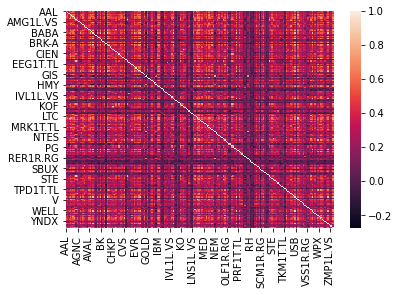

count    3654.000000
mean        0.006939
std         0.056991
min        -0.599310
25%        -0.014641
50%         0.009596
75%         0.035379
max         0.214985
Name: Portfolio, dtype: float64

In [20]:
ret = prices.pct_change().dropna()
ret['Portfolio'] = ret[portfolio].mean(axis=1)
wret = prices.asfreq(freq='W', method='ffill').pct_change().dropna()
wretRoll = prices.pct_change(7).dropna()
mret = prices.pct_change(28).fillna(0.0)
mret['Portfolio'] = mret[portfolio].mean(axis=1)
mretRoll = prices.pct_change(22).dropna()
mretRoll['Portfolio'] = mretRoll[portfolio].mean(axis=1).fillna(0.0)

log_ret = np.log(prices.div(prices.shift(1))).fillna(0.0)
log_ret['Portfolio'] = log_ret[portfolio].mean(axis=1).fillna(0.0)
mlogret = np.log(prices/prices.shift(1)).rolling(28).sum().fillna(0.0)
mlogret['Portfolio'] = mlogret[portfolio].mean(axis=1)

profiles['Beta'] = mlogret.cov()['Portfolio']/mlogret.drop('Portfolio', axis=1).var().loc[profiles.index]

profiles.to_csv('Company profiles.csv')

sns.heatmap(mretRoll.corr())
plt.show();

mlogret['Portfolio'].describe()

# Portfolio Analysis

In [21]:
#Need to add Price to Earnings and Price to Book to profiles
profiles.loc[portfolio]

,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD
O,Realty Income Corporation,Real Estate,REIT—Retail,HOLD,57.09,0.636423,0.028563,0.189965
ITUB,Itau Unibanco Holding S.A.,Financial Services,Banks—Regional,HOLD,52.62,0.362424,0.005428,0.330294
LTC,"LTC Properties, Inc.",Real Estate,REIT—Healthcare Facilities,HOLD,52.48,0.612117,0.023080,0.206445
V,Visa Inc.,Financial Services,Credit Services,HOLD,63.22,0.698445,0.056943,0.170060
EVR,Evercore Inc.,Financial Services,Capital Markets,SELL,49.08,0.428521,0.022255,0.295278


In [22]:
profiles.groupby('Industry')['Name'].count()

Industry
Basic Materials            9
Communication Services    18
Consumer Cyclical         25
Consumer Defensive        20
Energy                     9
Financial Services        24
Healthcare                17
Industrials               16
Real Estate               12
Technology                23
Utilities                 11
Name: Name, dtype: int64

## Sectors invested

In [23]:
portIndCount = profiles.loc[portfolio]['Industry'].drop_duplicates().count()
industryCount = profiles['Industry'].drop_duplicates().count()

profiles.loc[portfolio].groupby('Industry')['Name'].count()

Industry
Financial Services    3
Real Estate           2
Name: Name, dtype: int64

## Plot graphs

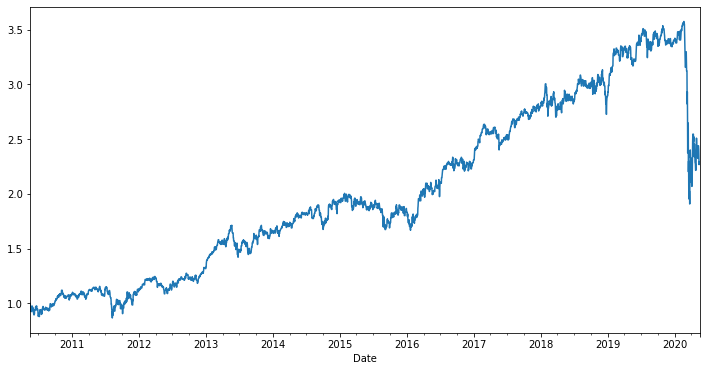

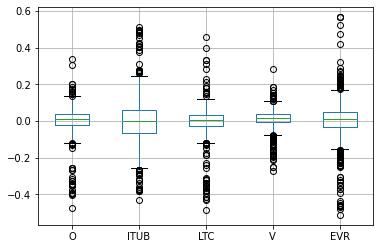

In [24]:
portfolioGrowth = pd.Series(np.cumprod(np.exp(log_ret['Portfolio'])))
portfolioGrowth.plot(figsize=(12,6))
plt.show();

mretRoll[portfolio].boxplot()
plt.show();

# Filtering down the investment opportunities

In [60]:
buyable = profiles.copy()

for ind in profiles.loc[portfolio, 'Industry'].drop_duplicates().values:
    buyable = buyable[buyable['Industry'] != ind]

buyable = buyable[buyable['Action'] != 'SELL']
industryBest = []

for ind in buyable['Industry'].drop_duplicates().values:
    portIndC = int(round(profiles.loc[portfolio].groupby('Industry').count().mean(axis=1).median(),0))
    if buyable.loc[np.logical_and(buyable['Industry'] == ind, buyable['RET'] > 0.03),:].count()['Name'] >= portIndC:
        industryBest += buyable[np.logical_and(buyable['Industry'] == ind,buyable['RET'] > 0.03)].index[:3].to_list()

buyable = buyable.loc[industryBest]
buyable

,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD,Added Sharpe
FB,"Facebook, Inc.",Communication Services,Internet Content & Information,BUY,69.00,0.210519,0.069712,0.307802,0.483937
CHTR,"Charter Communications, Inc.",Communication Services,Entertainment,HOLD,60.08,0.408880,0.065154,0.217282,0.468141
NTES,"NetEase, Inc.",Communication Services,Internet Content & Information,HOLD,50.44,0.165520,0.049492,0.296403,0.413714
REGN,"Regeneron Pharmaceuticals, Inc.",Healthcare,Biotechnology,HOLD,55.84,0.087104,0.064544,0.335508,0.466407
UNH,UnitedHealth Group Incorporated,Healthcare,Healthcare Plans,HOLD,57.18,0.455149,0.049639,0.186462,0.435817
OLF1R.RG,AS Olainfarm,Healthcare,Drug Manufacturers—Specialty & Generic,HOLD,51.63,0.215265,0.053398,0.274723,0.432890
NVDA,NVIDIA Corporation,Technology,Semiconductors,HOLD,56.13,0.164986,0.073446,0.354619,0.462029
MSI,"Motorola Solutions, Inc.",Technology,Communication Equipment,HOLD,59.82,0.465512,0.049077,0.184371,0.435018
ADBE,Adobe Inc.,Technology,Software—Infrastructure,HOLD,56.17,0.437859,0.053513,0.208766,0.431630
BAH,Booz Allen Hamilton Holding Corporation,Industrials,Consulting Services,HOLD,57.45,0.282182,0.056760,0.223328,0.459429


In [0]:
#names = ['NVDA','TSLA','ADBE','BABA']
#period = 22
#backtestMLmomentum(prices[names], hPeriod=period, getPrediction=True)

## Calculating how much assets add to portfolios Sharpe ratio



In [27]:
profiles['Added Sharpe'] = 0.0

portfolioSharpe = mret[portfolio].mean(axis=1).mean()/mret[portfolio].mean(axis=1).std()

for n in profiles.index:
    t = portfolio[:]
    t.append(n)    
    mu = profiles.loc[t,'RET'].mean()
    sigma = mret[t].mean(axis=1).std()
    profiles.loc[n, 'Added Sharpe'] = mu/sigma - portfolioSharpe

print('Most added value:')
profiles = profiles.sort_values(by='Added Sharpe', ascending=False)
profiles.to_csv('Company profiles.csv')
profiles[profiles['Added Sharpe'] > profiles['Added Sharpe'].quantile(0.95)]

Most added value:


,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD,Added Sharpe
FB,"Facebook, Inc.",Communication Services,Internet Content & Information,BUY,69.00,0.210519,0.069712,0.307802,0.483937
MA,Mastercard Incorporated,Financial Services,Credit Services,HOLD,62.68,0.590874,0.065997,0.183697,0.476490
CHTR,"Charter Communications, Inc.",Communication Services,Entertainment,HOLD,60.08,0.408880,0.065154,0.217282,0.468141
REGN,"Regeneron Pharmaceuticals, Inc.",Healthcare,Biotechnology,HOLD,55.84,0.087104,0.064544,0.335508,0.466407
NVDA,NVIDIA Corporation,Technology,Semiconductors,HOLD,56.13,0.164986,0.073446,0.354619,0.462029
SMA1R.RG,AS PATA Saldus,Basic Materials,Lumber & Wood Production,SELL,32.01,0.008058,0.070699,0.541068,0.460952
BAH,Booz Allen Hamilton Holding Corporation,Industrials,Consulting Services,HOLD,57.45,0.282182,0.056760,0.223328,0.459429
V,Visa Inc.,Financial Services,Credit Services,HOLD,63.22,0.698445,0.056943,0.170060,0.448087
AMZN,"Amazon.com, Inc.",Consumer Cyclical,Internet Retail,HOLD,54.78,0.236974,0.055879,0.249401,0.446344
LNR1L.VS,AB Ignitis gamyba,Utilities,Utilities—Regulated Electric,SELL,45.00,0.054315,0.040024,0.211987,0.445668


## Filtering out industries in which portfolio is already invested in

In [28]:
portfolio_ind = profiles.loc[portfolio].groupby('Industry').count()['Name']
portfolio_subind = profiles.loc[portfolio].groupby('Sub-Industry').count()['Name']

#print(portfolio_subind)
selection = profiles
industryCount = len(profiles.groupby('Industry').count().index)
subIndustryCount = len(profiles.groupby('Sub-Industry').count().index)

port_Ind_fully_invested = len(portfolio_ind.index) == industryCount
port_subInd_fully_invested = len(portfolio_subind.index) == subIndustryCount

for i in portfolio_ind.index:
    if port_Ind_fully_invested:
        if portfolio_ind.loc[i] == portfolio_ind.min():
            selection = selection[selection['Industry'] == i]
        else:
            selection = selection[selection['Industry'] != i]
    else:
        selection = selection[selection['Industry'] != i]
for i in portfolio_subind.index:
    if port_subInd_fully_invested:
        if portfolio_subind.loc[i] == portfolio_subind.min():
            selection = selection[selection['Industry'] == i]
        else:
            selection = selection[selection['Industry'] != i]
    else:
        selection = selection[selection['Sub-Industry'] != i]

selection = selection[selection['Action'] != 'SELL']
selection.sort_values(by=['Beta', 'Profit Prob.'])

,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD,Added Sharpe
REGN,"Regeneron Pharmaceuticals, Inc.",Healthcare,Biotechnology,HOLD,55.84,0.087104,0.064544,0.335508,0.466407
NFLX,"Netflix, Inc.",Communication Services,Entertainment,HOLD,55.90,0.092865,0.067690,0.474802,0.405486
RH,RH,Consumer Cyclical,Specialty Retail,HOLD,58.80,0.121326,0.058385,0.530537,0.394390
RGLD,"Royal Gold, Inc.",Basic Materials,Gold,HOLD,51.40,0.124308,0.027562,0.358636,0.328060
INCY,Incyte Corporation,Healthcare,Biotechnology,HOLD,50.22,0.128091,0.047338,0.387818,0.374935
...,...,...,...,...,...,...,...,...,...
PG,The Procter & Gamble Company,Consumer Defensive,Household & Personal Products,HOLD,51.32,0.726530,0.021169,0.123064,0.356796
WM,"Waste Management, Inc.",Industrials,Waste Management,HOLD,63.43,0.762276,0.039382,0.141802,0.402628
ADP,"Automatic Data Processing, Inc.",Industrials,Staffing & Employment Services,HOLD,64.50,0.762867,0.046546,0.159835,0.414379
PEP,"PepsiCo, Inc.",Consumer Defensive,Beverages—Non-Alcoholic,HOLD,59.76,0.790774,0.028666,0.124646,0.379995


## Filtering assets with lowest downside correlation with portfolio

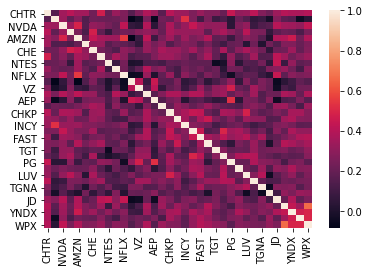

Lowest correlating assets:


,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD,Added Sharpe
REGN,"Regeneron Pharmaceuticals, Inc.",Healthcare,Biotechnology,HOLD,55.84,0.087104,0.064544,0.335508,0.466407
NFLX,"Netflix, Inc.",Communication Services,Entertainment,HOLD,55.90,0.092865,0.067690,0.474802,0.405486
RH,RH,Consumer Cyclical,Specialty Retail,HOLD,58.80,0.121326,0.058385,0.530537,0.394390
RGLD,"Royal Gold, Inc.",Basic Materials,Gold,HOLD,51.40,0.124308,0.027562,0.358636,0.328060
INCY,Incyte Corporation,Healthcare,Biotechnology,HOLD,50.22,0.128091,0.047338,0.387818,0.374935
ETSY,"Etsy, Inc.",Consumer Cyclical,Internet Retail,HOLD,54.40,0.128351,0.057114,0.556536,0.408166
TSLA,"Tesla, Inc.",Consumer Cyclical,Auto Manufacturers,HOLD,52.26,0.139625,0.079459,0.493654,0.415671
JD,"JD.com, Inc.",Consumer Cyclical,Internet Retail,HOLD,51.78,0.158624,0.013794,0.303509,0.321948
NVDA,NVIDIA Corporation,Technology,Semiconductors,HOLD,56.13,0.164986,0.073446,0.354619,0.462029
NTES,"NetEase, Inc.",Communication Services,Internet Content & Information,HOLD,50.44,0.165520,0.049492,0.296403,0.413714


In [29]:
selAss = selection.index.to_list()
ret = ret[selAss+['Portfolio']]
low_corr = ret[ret['Portfolio'] < 0.0].corr()[ret.corr()['Portfolio'] <= ret.corr()['Portfolio'].quantile(0.50)]

sns.heatmap(mretRoll.corr().loc[low_corr.index, low_corr.index])
plt.show();

print('Lowest correlating assets:')
profiles.loc[low_corr.index].sort_values(by='Beta')

## Checking industries with lowest Beta against portfolio

In [30]:
profiles.loc[low_corr.index].groupby('Industry')['Beta'].mean()

Industry
Basic Materials           0.124308
Communication Services    0.266876
Consumer Cyclical         0.181626
Consumer Defensive        0.492736
Energy                    0.215196
Healthcare                0.275679
Industrials               0.377146
Technology                0.305630
Utilities                 0.529397
Name: Beta, dtype: float64

In [31]:
profiles.loc[low_corr.index].groupby(['Industry','Sub-Industry'])['Beta'].mean()

Industry                Sub-Industry                          
Basic Materials         Gold                                      0.124308
Communication Services  Broadcasting                              0.273763
                        Entertainment                             0.250873
                        Internet Content & Information            0.189658
                        Telecom Services                          0.356654
Consumer Cyclical       Auto Manufacturers                        0.139625
                        Auto Parts                                0.304857
                        Internet Retail                           0.174650
                        Specialty Retail                          0.121326
Consumer Defensive      Discount Stores                           0.258942
                        Household & Personal Products             0.726530
Energy                  Oil & Gas E&P                             0.186557
                        Oil & Gas Mid

# Selecting assets from the filtered assets

## Checking for BUY signals with simple Momemntum strategies

In [32]:
niceStocks = []
for a in low_corr.index:
    signTable = pd.DataFrame(momentumBuy(prices[a], a, rper=22, output='current'), 
                             columns=list(['LAG','Signal','Profit Prob.','Return']))
    
    ts = momentumBuy(prices[a], a, rper=22, output='ts')        
    stateTable = ts.groupby(['Signal','BuySignal'])['Returns'].mean()
    currSt = ts.iloc[-1][['Signal','BuySignal']]
    expRet = round(stateTable[(currSt['Signal'], currSt['BuySignal'])], 3)
    pProb = signTable['Profit Prob.'].mean()

    smplState, smplRet, smplProb = simpleMomentum(prices[a], per=22, output='triple')

    if (signTable['Profit Prob.'].mean() >= 0.70 and expRet >= 0.05) or (smplState=='BUY' and smplProb >= 60):
        minRet = int(10000*min(expRet,smplRet))/100
        maxRet = int(10000*max(expRet,smplRet))/100
        minProb = int(10000*min(pProb,smplProb))/100
        maxProb = int(10000*max(pProb,smplProb))/100
        print('{} expected return: {}% - {}% ({}% - {}%)'.format(a, minRet,maxRet,
                                                                 minProb,maxProb))
        niceStocks.append(a)

REGN expected return: 2.38% - 6.8% (55.83% - 74.23%)
NVDA expected return: 2.75% - 6.6% (56.13% - 79.04%)
TSLA expected return: 3.57% - 10.1% (52.26% - 74.96%)
NTES expected return: 1.35% - 5.6% (50.43% - 72.02%)
ETSY expected return: 4.73% - 7.6% (54.39% - 75.32%)
NFLX expected return: 2.57% - 6.0% (55.9% - 79.56%)


In [33]:
profiles.loc[np.logical_or(profiles['Action'] == 'BUY',profiles['Action'] == 'STRONG BUY')]

,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD,Added Sharpe
FB,"Facebook, Inc.",Communication Services,Internet Content & Information,BUY,69.00,0.210519,0.069712,0.307802,0.483937
VZ,Verizon Communications Inc.,Communication Services,Telecom Services,STRONG BUY,54.38,0.453526,0.032786,0.143812,0.400847


In [34]:
profiles.loc[niceStocks+['FB','AAPL','MSFT','IBM','O','TSLA','AMZN','GOOG']]

,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD,Added Sharpe
REGN,"Regeneron Pharmaceuticals, Inc.",Healthcare,Biotechnology,HOLD,55.84,0.087104,0.064544,0.335508,0.466407
NVDA,NVIDIA Corporation,Technology,Semiconductors,HOLD,56.13,0.164986,0.073446,0.354619,0.462029
TSLA,"Tesla, Inc.",Consumer Cyclical,Auto Manufacturers,HOLD,52.26,0.139625,0.079459,0.493654,0.415671
NTES,"NetEase, Inc.",Communication Services,Internet Content & Information,HOLD,50.44,0.165520,0.049492,0.296403,0.413714
ETSY,"Etsy, Inc.",Consumer Cyclical,Internet Retail,HOLD,54.40,0.128351,0.057114,0.556536,0.408166
NFLX,"Netflix, Inc.",Communication Services,Entertainment,HOLD,55.90,0.092865,0.067690,0.474802,0.405486
FB,"Facebook, Inc.",Communication Services,Internet Content & Information,BUY,69.00,0.210519,0.069712,0.307802,0.483937
AAPL,Apple Inc.,Technology,Consumer Electronics,HOLD,55.49,0.312420,0.047399,0.224170,0.416312
MSFT,Microsoft Corporation,Technology,Software—Infrastructure,HOLD,55.14,0.490672,0.045861,0.175723,0.423017
IBM,International Business Machines Corporation,Technology,Information Technology Services,HOLD,50.79,0.536427,0.013457,0.181006,0.304930


# Machine Learning asses selection

## Checking out assets that are chosen by simple Momentum strategy first

In [35]:
strongBuy = profiles.loc[profiles['Action'] == 'Strong Buy']
if len(strongBuy.index) > 0:
    strongBuy['STR'] = backtestMLmomentum(prices[strongBuy.index], hPeriod=22, 
                                          getPrediction=True)
strongBuy

,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD,Added Sharpe


In [36]:
buy = profiles.loc[profiles['Action'] == 'Buy']
if len(buy.index) > 0:
    buy['STR'] = backtestMLmomentum(prices[buy.index], hPeriod=22, 
                                    getPrediction=True)
buy

,Name,Industry,Sub-Industry,Action,Profit Prob.,Beta,RET,STD,Added Sharpe


## Checking what ML thinks about the assets in portfolio

In [0]:
#backtestMLmomentum(prices[portfolio], hPeriod=22, getPrediction=True, opt=True)

## Getting ML forecasts for filtered assets

In [38]:
investable = profiles.loc[low_corr.index.to_list()]
investable['STR'] = backtestMLmomentum(prices[investable.index], hPeriod=22, 
                                       getPrediction=True, opt=True)

investable.sort_values(by='RET', ascending=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

ValueError: ignored

In [0]:
investable[investable['STR']==1].sort_values(by='RET', ascending=False)

In [0]:
diverse = profiles.loc[selAss]
diverse = diverse[diverse['Action']!='SELL']

diverse['STR'] = backtestMLmomentum(prices[diverse.index], hPeriod=22, 
                                    getPrediction=True, opt=True)
diverse = diverse[diverse['STR'] == 1].sort_values(by='RET')
diverse

In [0]:
sharpe = diverse[np.logical_and(diverse['Added Sharpe'] > max(0.0,profiles['Added Sharpe'].quantile(0.5)), 
                                diverse['Beta'] < profiles.loc[portfolio,'Beta'].min())]
sharpe[sharpe['Action']!='SELL']